<a href="https://colab.research.google.com/github/LIYunzhe1408/Facial-Keypoint-Detection/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [1]:
# Fetch data
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

mkdir: cannot create directory ‘data’: File exists
--2025-04-15 02:19:21--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.202.64, 3.5.0.41, 52.216.153.158, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.202.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘data/train-test-data.zip.11’

train-test-data.zip 100%[===================>] 322.93M  75.8MB/s    in 4.3s    

2025-04-15 02:19:26 (74.5 MB/s) - ‘data/train-test-data.zip.11’ saved [338613624/338613624]

Archive:  data/train-test-data.zip


# Setup Environment

In [ ]:
# No need if you are using colab

# !pip install matplotlib~=3.5.2
# !pip install scikit-image==0.19.2
# !pip install torch~=1.8.1
# !pip install torchvision~=0.9.1
# !pip install numpy~=1.21.6
# !pip install pillow~=9.1.1
# !pip install tqdm~=4.64.0
# !pip install jupyter==1.0.0
# !pip install opencv-python==4.6.0.66
# !pip install pandas==1.3.5


# Visualize the data

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


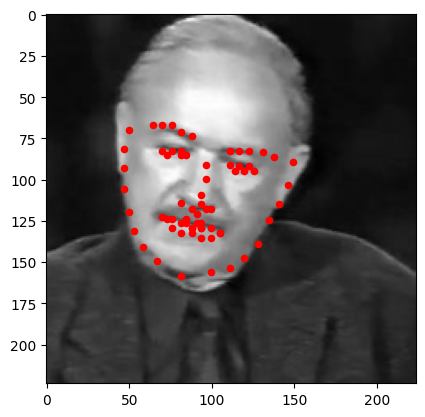

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image black and white
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    plt.show()
    break


## Part1-SimpleNet
Find best hyperparameters
* Loss Function
* Learning Rate
* Optimizer
* Dropout Layer weights

In [ ]:
from models import SimpleNet
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}.pth"
        best_val_loss = float("inf")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# ===================================
# Part 1 Net
# Loss Function
# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()

# net_batch_64 = SimpleNet()
# net_LR_05 = SimpleNet()
# net_LR_00005 = SimpleNet()

# net_AdamW = SimpleNet()
net_dropout_all_02 = SimpleNet()


# ========== HYPERPARAMETERS ==========
n_epochs = 10
# optimizer_smoothL1 = optim.Adam(net_LR_00005.parameters(), lr=0.0005)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)
optimizer = optim.AdamW(net_dropout_all_02.parameters(), lr=0.0005)


# ========== TRAIN MODELS ==========
# Loss Function
# SmoothL1_losses, val_SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)
# MSE_losses, val_MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE, test_loader)

# Batch Size
# LR_05_L1_loss, LR_05_L1_val_loss = train_net(net_LR_00005, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)

# AdamW_loss, AdamW_val_loss = train_net(net_AdamW, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

droupout_all_02_loss, droupout_all_02_val_loss = train_net(net_dropout_all_02, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)


### Evaluation-Viz

#### Loss function

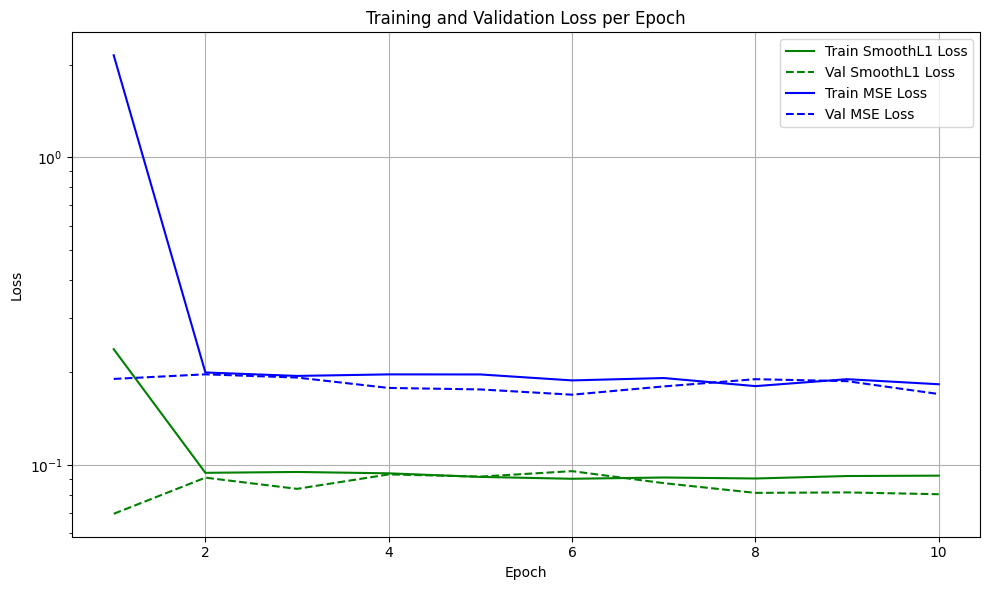

Final training loss: 0.09242875540443223, 0.18315610224338172
Final val loss: 0.08044344028357801, 0.17023054251865466
Best val loss (SmoothL1): 0.06948532591530011, epoch#: 0
Best val loss (MSE): 0.1693831400147506, epoch#: 5


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(SmoothL1_losses) + 1)

# plt.figure(figsize=(10, 6))

# # SmoothL1 loss curves
# plt.plot(epochs, SmoothL1_losses, label='Train SmoothL1 Loss', color='green', linestyle='-')
# plt.plot(epochs, val_SmoothL1_losses, label='Val SmoothL1 Loss', color='green', linestyle='--')

# # MSE loss curves
# plt.plot(epochs, MSE_losses, label='Train MSE Loss', color='blue', linestyle='-')
# plt.plot(epochs, val_MSE_losses, label='Val MSE Loss', color='blue', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {SmoothL1_losses[-1]}, {MSE_losses[-1]}')
# print(f'Final val loss: {val_SmoothL1_losses[-1]}, {val_MSE_losses[-1]}')

# best_val_loss = min(val_SmoothL1_losses)
# best_epoch = val_SmoothL1_losses.index(best_val_loss)
# print(f'Best val loss (SmoothL1): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(val_MSE_losses)
# best_epoch = val_MSE_losses.index(best_val_loss)
# print(f'Best val loss (MSE): {best_val_loss}, epoch#: {best_epoch}')


#### Batch Size

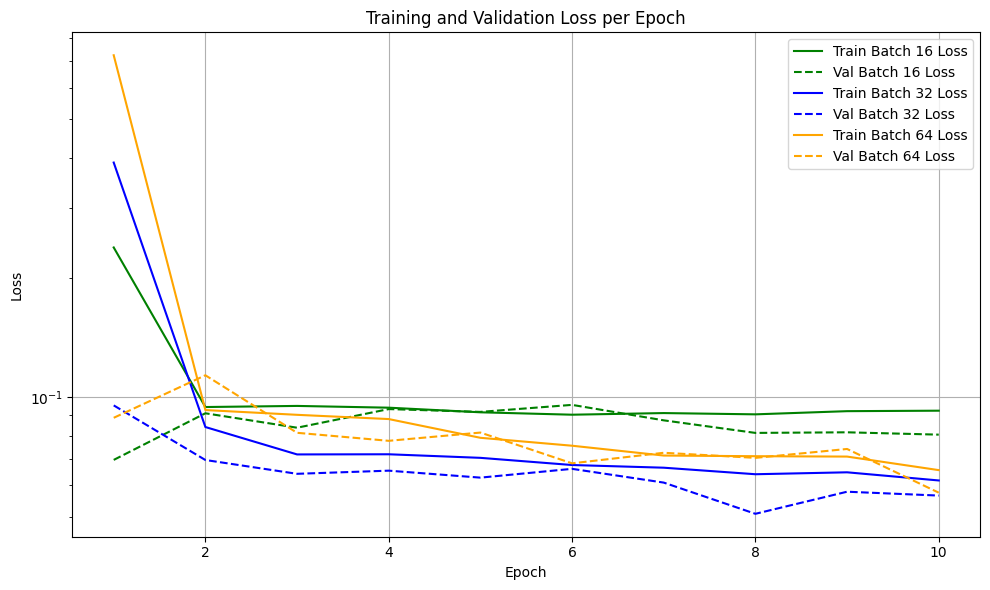

Final training loss: 0.09242875540443223, 0.06167978404789199, 0.06548963366943926
Final val loss: 0.08044344028357801, 0.056507733884966695, 0.05746516709373932
Best val loss (Batch 16): 0.06948532591530011, epoch#: 0
Best val loss (Batch 32): 0.05084166460482429, epoch#: 7
Best val loss (Batch 64): 0.05746516709373932, epoch#: 9


In [ ]:
# batch_16_L1_loss = SmoothL1_losses
# batch_16_L1_val_loss = val_SmoothL1_losses
# batch_16_L1_net = net_SmoothL1

# import matplotlib.pyplot as plt

# epochs = range(1, len(batch_16_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, batch_16_L1_loss, label='Train Batch 16 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_16_L1_val_loss, label='Val Batch 16 Loss', color='green', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train Batch 32 Loss', color='blue', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val Batch 32 Loss', color='blue', linestyle='--')

# # 64 loss curves
# plt.plot(epochs, batch_64_L1_loss, label='Train Batch 64 Loss', color='orange', linestyle='-')
# plt.plot(epochs, batch_64_L1_val_loss, label='Val Batch 64 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {batch_16_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {batch_64_L1_loss[-1]}')
# print(f'Final val loss: {batch_16_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {batch_64_L1_val_loss[-1]}')

# best_val_loss = min(batch_16_L1_val_loss)
# best_epoch = batch_16_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 16): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 32): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_64_L1_val_loss)
# best_epoch = batch_64_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 64): {best_val_loss}, epoch#: {best_epoch}')

#### Learning Rate

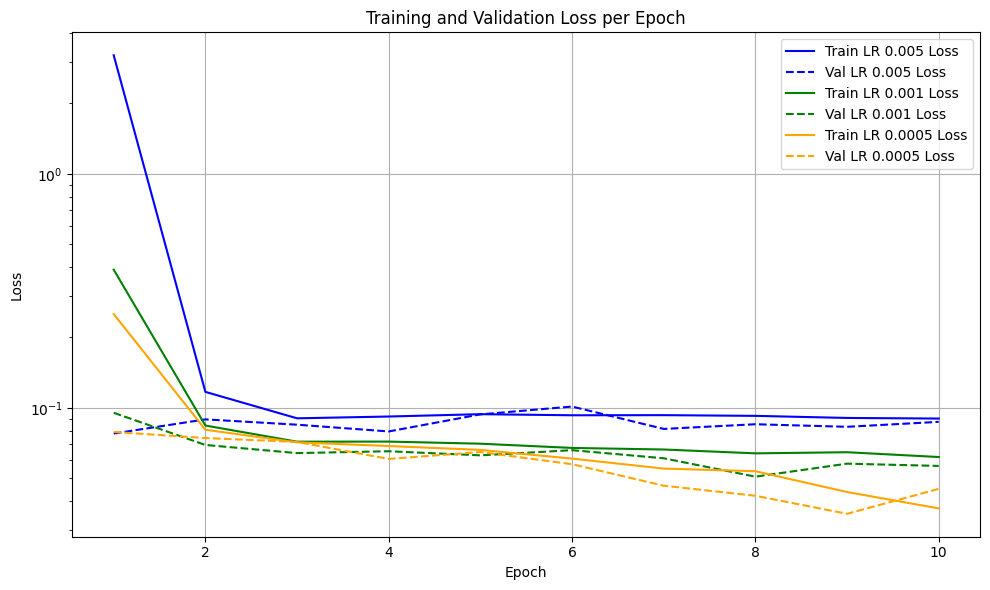

Final training loss: 0.037213279466794265, 0.06167978404789199, 0.09005379214909241
Final val loss: 0.04509976361784689, 0.056507733884966695, 0.08716710537090032
Best val loss (LR 0.005): 0.035286272131784334, epoch#: 8
Best val loss (LR 0.001): 0.05084166460482429, epoch#: 7
Best val loss (LR 0.0005): 0.07772143766586313, epoch#: 0


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, LR_00005_L1_loss, label='Train LR 0.005 Loss', color='blue', linestyle='-')
# plt.plot(epochs, LR_00005_L1_val_loss, label='Val LR 0.005 Loss', color='blue', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train LR 0.001 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val LR 0.001 Loss', color='green', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train LR 0.0005 Loss', color='orange', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val LR 0.0005 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {LR_00005_L1_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {LR_00005_L1_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.005): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.001): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(LR_00005_L1_val_loss)
# best_epoch = LR_00005_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.0005): {best_val_loss}, epoch#: {best_epoch}')

#### Optimizer

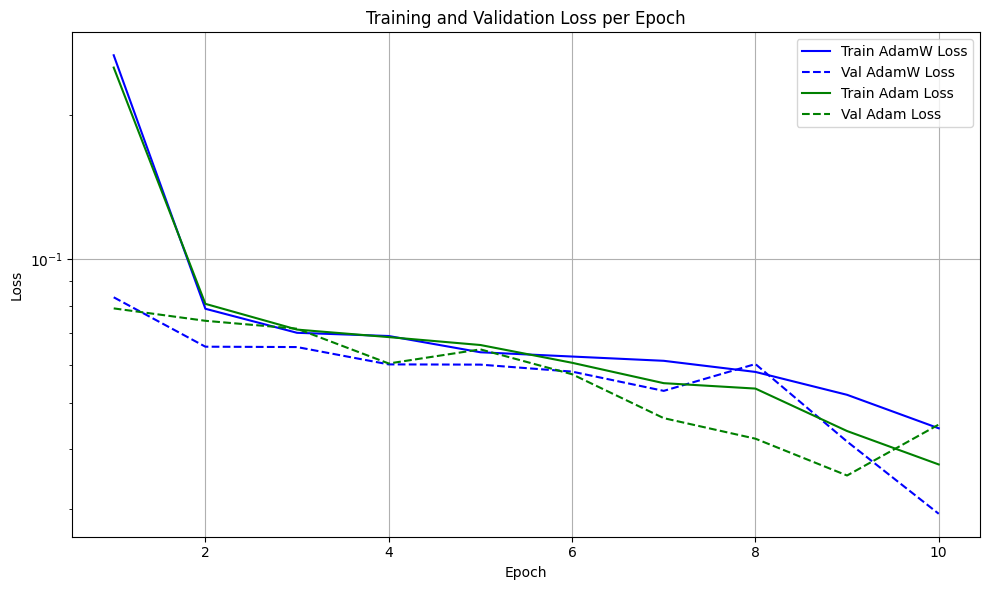

Final training loss: 0.037213279466794265, 0.04429485004647331
Final val loss: 0.04509976361784689, 0.02934233347240932
Best val loss (Adam): 0.035286272131784334, epoch#: 8
Best val loss (AdamW): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train AdamW Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val AdamW Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train Adam Loss', color='green', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val Adam Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Adam): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (AdamW): {best_val_loss}, epoch#: {best_epoch}')

#### Droupout

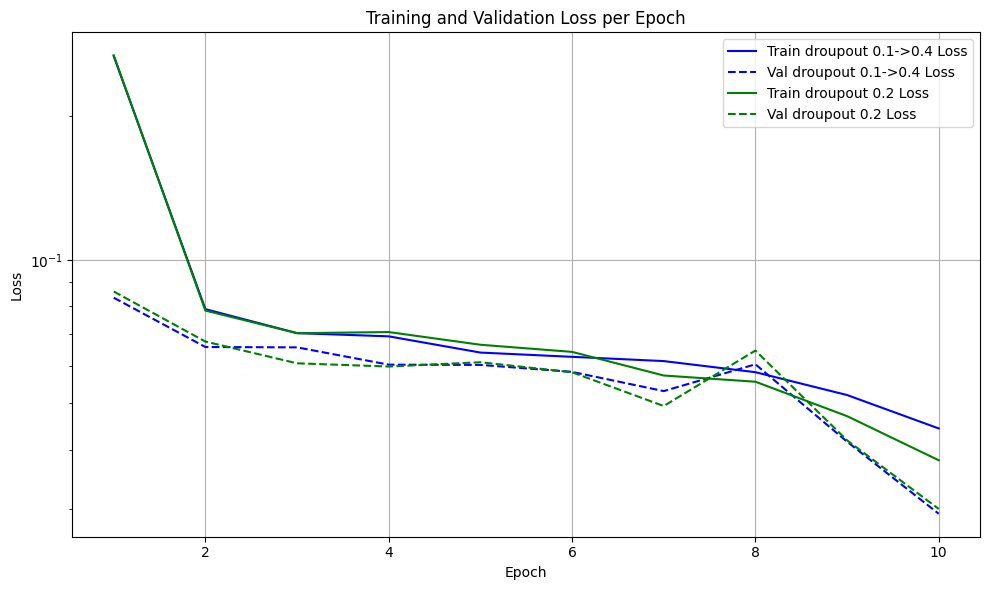

Final training loss: 0.03798806185916372, 0.04429485004647331
Final val loss: 0.030033955374372284, 0.02934233347240932
Best val loss (all 0.2): 0.030033955374372284, epoch#: 9
Best val loss (0.1->0.4): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(AdamW_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train droupout 0.1->0.4 Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val droupout 0.1->0.4 Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, droupout_all_02_loss, label='Train droupout 0.2 Loss', color='green', linestyle='-')
# plt.plot(epochs, droupout_all_02_val_loss, label='Val droupout 0.2 Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {droupout_all_02_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {droupout_all_02_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(droupout_all_02_val_loss)
# best_epoch = droupout_all_02_val_loss.index(best_val_loss)
# print(f'Best val loss (all 0.2): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (0.1->0.4): {best_val_loss}, epoch#: {best_epoch}')

### Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")
# calcMSE(batch_16_L1_net)
# calcMSE(net_batch_32)
# calcMSE(net_LR_05)
# calcMSE(net_LR_00005)
# calcMSE(net_AdamW)
# calcMSE(net_batch_64)
# calcMSE(net_dropout_all_02)

## Part2-Transfer Learning

### General Train
* loss function: `SmoothL1Loss`
* Batch size: 32

In [ ]:
from models import Resnet18Grayscale, Resnet34Grayscale, DINOv2Keypoint
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()
            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}.pth"
        best_val_loss = float("inf")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

### ResNet

#### ResNet-Training
* ResNet18
* ResNet34
* Training Process: 5 for backbone + 10 for entire model

In [ ]:
def train_resnet(resnet, model_name):
  n_epochs_backbone_freeze = 5
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in resnet.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
  loss, val_loss = train_net(resnet, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = resnet

  # Fine-tune
  for param in resnet.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.Adam(resnet.parameters(), lr=0.0001)
  fine_tune_loss, fine_tune_val_loss = train_net(resnet, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, resnet


resnet18 = Resnet18Grayscale()
resnet34 = Resnet34Grayscale()

resnet18_fine_tune_loss, resnet18_fine_tune_val_loss, resnet18 = train_resnet(resnet18, "resnet18_5_10")
resnet34_fine_tune_loss, resnet34_fine_tune_val_loss, resnet34 = train_resnet(resnet34, "resnet34_5_10")

#### ResNet-Evaluation-Viz

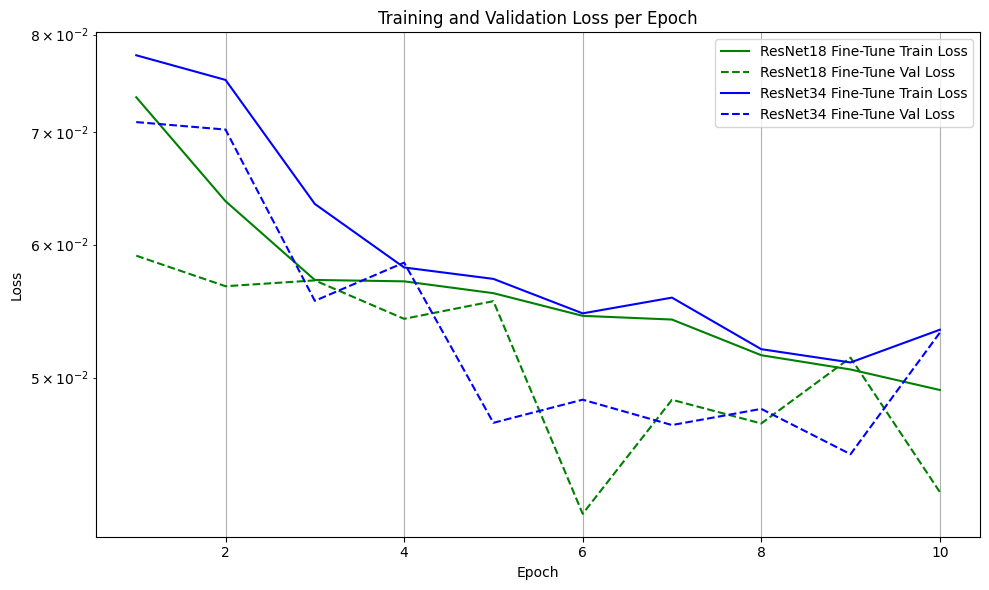

Final training loss: 0.05338959982986063, 0.04915943137400185
Final val loss: 0.05317371781113799, 0.04274732114237653
Best val loss: 0.04501998243019869, epoch#: 8
Best val loss: 0.04149022133407112, epoch#: 5


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(resnet18_fine_tune_loss) + 1)

plt.figure(figsize=(10, 6))


# plt.plot(epochs, resnet18_loss, label='ResNet18 Frozen Backbone Train Loss', color='blue', linestyle='-')
# plt.plot(epochs, resnet18_val_loss, label='ResNet18 Frozen Backbone Val Loss', color='blue', linestyle='--')


plt.plot(epochs, resnet18_fine_tune_loss, label='ResNet18 Fine-Tune Train Loss', color='green', linestyle='-')
plt.plot(epochs, resnet18_fine_tune_val_loss, label='ResNet18 Fine-Tune Val Loss', color='green', linestyle='--')
plt.plot(epochs, resnet34_fine_tune_loss, label='ResNet34 Fine-Tune Train Loss', color='blue', linestyle='-')
plt.plot(epochs, resnet34_fine_tune_val_loss, label='ResNet34 Fine-Tune Val Loss', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {resnet34_fine_tune_loss[-1]}, {resnet18_fine_tune_loss[-1]}')
print(f'Final val loss: {resnet34_fine_tune_val_loss[-1]}, {resnet18_fine_tune_val_loss[-1]}')

best_val_loss = min(resnet34_fine_tune_val_loss)
best_epoch = resnet34_fine_tune_val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

best_val_loss = min(resnet18_fine_tune_val_loss)
best_epoch = resnet18_fine_tune_val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

#### ResNet-Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")


calcMSE(resnet18)
calcMSE(resnet34)

### DINO

#### DINO-Training

In [ ]:
def train_dino(dino, model_name):
  n_epochs_backbone_freeze = 5
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in dino.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.AdamW(filter(lambda p: p.requires_grad, dino.parameters()), lr=1e-3)
  loss, val_loss = train_net(dino, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = dino

  # Fine-tune
  for param in dino.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.AdamW(dino.parameters(), lr=1e-4)
  fine_tune_loss, fine_tune_val_loss = train_net(dino, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, dino


dino = DINOv2Keypoint()

train_loss, val_loss, dino = train_dino(dino, "dino")

epoch 0:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

training:  20%|██        | 1/5 [01:09<04:37, 69.29s/it]

Saved best model (Val Loss: 0.1015)
Epoch 1/5 | Train Loss: 0.1042 | Val Loss: 0.1015



training:  40%|████      | 2/5 [02:15<03:22, 67.52s/it]

Saved best model (Val Loss: 0.0844)
Epoch 2/5 | Train Loss: 0.0989 | Val Loss: 0.0844



training:  60%|██████    | 3/5 [03:21<02:13, 66.73s/it]

Saved best model (Val Loss: 0.0905)
Epoch 3/5 | Train Loss: 0.0928 | Val Loss: 0.0905



training:  80%|████████  | 4/5 [04:27<01:06, 66.38s/it]

Saved best model (Val Loss: 0.0858)
Epoch 4/5 | Train Loss: 0.0936 | Val Loss: 0.0858



training: 100%|██████████| 5/5 [05:33<00:00, 66.66s/it]


Saved best model (Val Loss: 0.0924)
Epoch 5/5 | Train Loss: 0.0967 | Val Loss: 0.0924


training:  10%|█         | 1/10 [02:44<24:42, 164.69s/it]

Saved best model (Val Loss: 0.0881)
Epoch 1/10 | Train Loss: 0.0958 | Val Loss: 0.0881



training:  20%|██        | 2/10 [05:30<22:01, 165.19s/it]

Saved best model (Val Loss: 0.0840)
Epoch 2/10 | Train Loss: 0.0972 | Val Loss: 0.0840



training:  30%|███       | 3/10 [08:15<19:15, 165.03s/it]

Saved best model (Val Loss: 0.0883)
Epoch 3/10 | Train Loss: 0.0965 | Val Loss: 0.0883



training:  40%|████      | 4/10 [11:00<16:30, 165.14s/it]

Saved best model (Val Loss: 0.0844)
Epoch 4/10 | Train Loss: 0.0939 | Val Loss: 0.0844



training:  50%|█████     | 5/10 [13:45<13:44, 164.98s/it]

Saved best model (Val Loss: 0.0857)
Epoch 5/10 | Train Loss: 0.0912 | Val Loss: 0.0857



training:  60%|██████    | 6/10 [16:30<11:00, 165.12s/it]

Saved best model (Val Loss: 0.0862)
Epoch 6/10 | Train Loss: 0.0920 | Val Loss: 0.0862



training:  70%|███████   | 7/10 [19:15<08:15, 165.10s/it]

Saved best model (Val Loss: 0.0824)
Epoch 7/10 | Train Loss: 0.0901 | Val Loss: 0.0824



training:  80%|████████  | 8/10 [22:00<05:30, 165.01s/it]

Saved best model (Val Loss: 0.0904)
Epoch 8/10 | Train Loss: 0.0949 | Val Loss: 0.0904



training:  90%|█████████ | 9/10 [24:45<02:45, 165.21s/it]

Saved best model (Val Loss: 0.0860)
Epoch 9/10 | Train Loss: 0.0922 | Val Loss: 0.0860



training: 100%|██████████| 10/10 [27:31<00:00, 165.12s/it]

Saved best model (Val Loss: 0.0796)
Epoch 10/10 | Train Loss: 0.0919 | Val Loss: 0.0796


#### DiNO-Evaluation-Viz

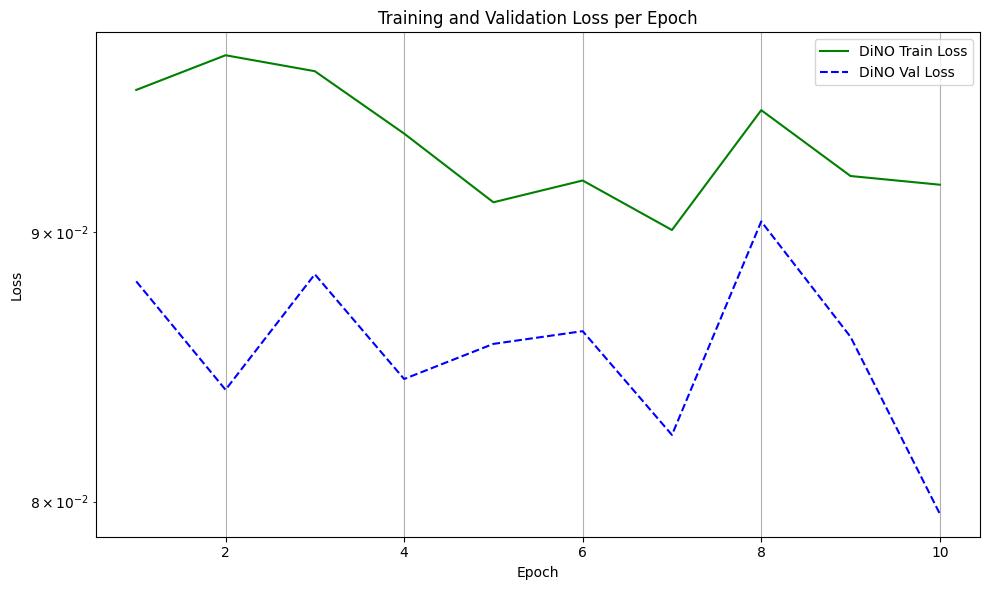

Final training loss: 0.09186892199419137
Final val loss: 0.07957467078488205
Best val loss: 0.07957467078488205, epoch#: 9


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))


plt.plot(epochs, train_loss, label='DiNO Train Loss', color='green', linestyle='-')
plt.plot(epochs, val_loss, label='DiNO Val Loss', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_loss[-1]}')
print(f'Final val loss: {val_loss[-1]}')

best_val_loss = min(val_loss)
best_epoch = val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

#### DINO-Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")

dino_pred = DINOv2Keypoint()
dino_pred.load_state_dict(torch.load("./models/dino.pth"))
calcMSE(dino_pred)

Test Mean Squared Error: 0.1720


# Train your model

# Visualize the model predictions

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


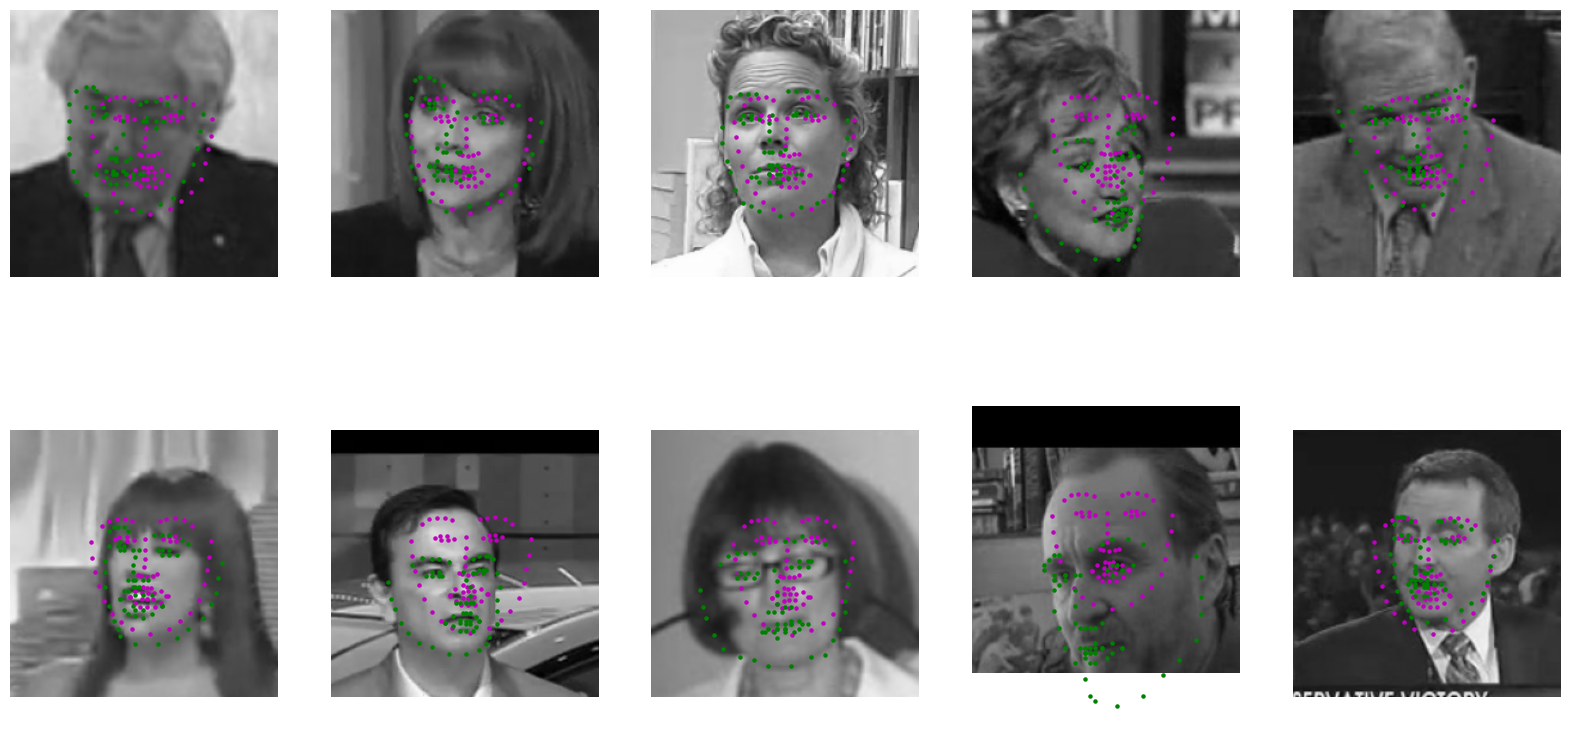

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()



net = dino_pred
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

## Part3-Heatmap Based

### Data Prep

tensor(0.3052) torch.Size([1, 224, 224])


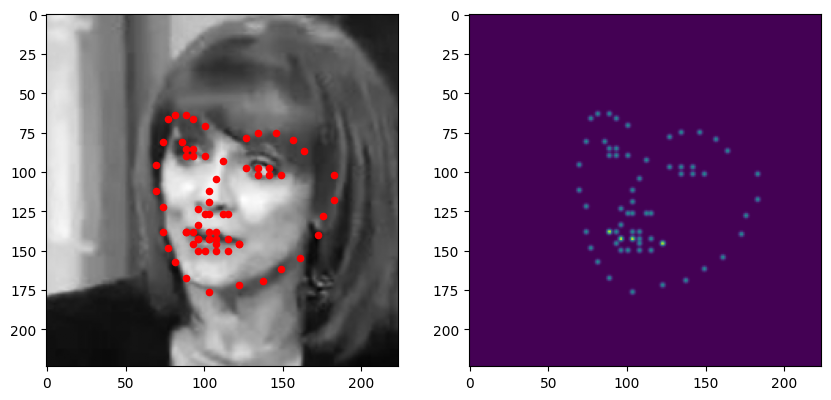

In [28]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsHeatmapDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsHeatmapDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
    output_size=224,
    sigma=1
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsHeatmapDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform,
    output_size=224,
    sigma=1
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    # show the heatmaps
    plt.subplot(1, 2, 2)
    heatmaps = sample['heatmaps'][0].sum(dim=0).unsqueeze(0)
    print(heatmaps.max(), sample['heatmaps'][0][0].unsqueeze(0).shape)
    plt.imshow(heatmaps.numpy().transpose(1, 2, 0))
    plt.show()
    break


### Overfit Exercise

In [7]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.conv(x)))

class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, padding=1, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activate(self.bn(self.upconv(x)))


# class Flatten(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pool = nn.AvgPool2d(kernel_size=7)
#         self.activation = nn.GELU()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.activation(self.pool(x)).view(x.size(0), -1)


# class Unflatten(nn.Module):
#     def __init__(self, in_channels: int, out_channels: int):
#         super().__init__()
#         self.convTrans = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=7, stride=7, padding=0)
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.activate = nn.GELU()

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = x.view(x.size(0), -1, 1, 1)
#         return self.activate(self.bn(self.convTrans(x)))

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size=56, stride=56)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.pool(x)      # (B, C, 1, 1)
        x = self.activation(x)
        return x.view(x.size(0), -1)   # (B, C)

class Unflatten(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=56, stride=56
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activate = nn.GELU()

    def forward(self, x):
        x = x.view(x.size(0), -1, 1, 1)   # (B, in_channels, 1, 1)
        x = self.convTrans(x)            # (B, out_channels, 56, 56)
        return self.activate(self.bn(x))



# Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        return self.conv2(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downConv = DownConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downConv(x)
        return self.conv_block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.upconv = UpConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upconv(x)
        return self.conv_block(x)

class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.initial_conv = ConvBlock(in_channels, num_hiddens)

        self.down1 = DownBlock(num_hiddens, num_hiddens)  # 28x28 -> 14x14
        self.down2 = DownBlock(num_hiddens, num_hiddens * 2)  # 14x14 -> 7x7

        self.flatten = Flatten()
        self.unflatten = Unflatten(num_hiddens * 2, num_hiddens * 2)

        self.up2 = UpBlock(num_hiddens * 4, num_hiddens)
        self.up1 = UpBlock(num_hiddens * 2, num_hiddens)
        self.last_to_second = ConvBlock(num_hiddens * 2, num_hiddens)
        # self.final_conv = nn.Conv2d(num_hiddens, in_channels, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(num_hiddens, 68, kernel_size=3, padding=1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (224, 224), "Expect input shape to be (224, 224)."

        x_init = self.initial_conv(x)
        x1 = self.down1(x_init)
        x2 = self.down2(x1)

        latent = self.flatten(x2)  # (B, num_hiddens*4, 1, 1)
        latent = self.unflatten(latent)  # (B, num_hiddens*4, 7, 7)
        # print("latent_unflattened: ", latent.shape)

        con = torch.cat([latent, x2], dim=1)  # Concatenation with downsampled feature map
        x = self.up2(con)  # (B, num_hiddens*2, 14, 14)


        con = torch.cat([x, x1], dim=1)  # Concatenation with initial feature map
        x = self.up1(con)  # (B, num_hiddens, 28, 28)


        con = torch.cat([x, x_init], dim=1)  # Concatenation with initial feature map
        x = self.last_to_second(con)  # (B, num_hiddens, 28, 28)
        # x = self.final_conv(x)  # Final convolution

        logits = self.final_conv(x)
        # print("logits: ", logits.shape)

        # --- Softmax over spatial dimension ---
        B, C, H, W = logits.shape  # B=Batch, C=68, H=224, W=224
        logits_flat = logits.view(B, C, -1)    # shape (B, 68, 50176)
        # print("logits_flat: ", logits_flat.shape)
        probs_flat = F.softmax(logits_flat, dim=2)
        probs = probs_flat.view(B, C, H, W)    # shape (B, 68, 224, 224)

        return probs

In [30]:
for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    heatmaps = sample['heatmaps'][0]
    break
# after the break:
image_single   = image.unsqueeze(0)       # shape (1, 1, 224, 224)
heatmaps_single = heatmaps.unsqueeze(0)   # shape (1, 68, 224, 224)

class SingleImageDataset(Dataset):
    def __init__(self, image, heatmaps):
        self.image = image
        self.heatmaps = heatmaps

    def __len__(self):
        return 1  # Only one sample

    def __getitem__(self, idx):
        return {
            "image": self.image[0],       # (1, 224, 224)
            "heatmaps": self.heatmaps[0]  # (68, 224, 224)
        }

# Instantiate it
single_ds = SingleImageDataset(image_single, heatmaps_single)
single_loader = DataLoader(single_ds, batch_size=1, shuffle=False)


model = UnconditionalUNet(in_channels=1, num_hiddens=128)
model = model.to(device)

criterion = nn.MSELoss(reduction='sum')  # or 'mean', but sum often helps
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Overfit on the single image
num_epochs = 500
for epoch in range(num_epochs):
    for batch in single_loader:
        # batch["image"] -> shape (1, 1, 224, 224)
        # batch["heatmaps"] -> shape (1, 68, 224, 224)

        imgs = batch["image"].to(device)
        hmaps = batch["heatmaps"].to(device)

        optimizer.zero_grad()

        outputs = model(imgs)  # (1, 68, 224, 224)
        loss = criterion(outputs, hmaps)
        loss.backward()
        optimizer.step()

    # Print the training loss each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.6f}")


Epoch 1/500 - Loss: 5.409990
Epoch 2/500 - Loss: 5.407088
Epoch 3/500 - Loss: 5.355879
Epoch 4/500 - Loss: 6.925104
Epoch 5/500 - Loss: 6.089769
Epoch 6/500 - Loss: 6.065145
Epoch 7/500 - Loss: 6.040097
Epoch 8/500 - Loss: 5.814856
Epoch 9/500 - Loss: 6.319107
Epoch 10/500 - Loss: 5.646477
Epoch 11/500 - Loss: 5.476830
Epoch 12/500 - Loss: 5.366584
Epoch 13/500 - Loss: 5.349320
Epoch 14/500 - Loss: 5.340129
Epoch 15/500 - Loss: 5.339825
Epoch 16/500 - Loss: 5.335468
Epoch 17/500 - Loss: 5.332915
Epoch 18/500 - Loss: 5.334735
Epoch 19/500 - Loss: 5.332989
Epoch 20/500 - Loss: 5.335927
Epoch 21/500 - Loss: 5.335513
Epoch 22/500 - Loss: 5.328687
Epoch 23/500 - Loss: 5.329909
Epoch 24/500 - Loss: 5.326364
Epoch 25/500 - Loss: 5.321767
Epoch 26/500 - Loss: 5.315243
Epoch 27/500 - Loss: 5.307291
Epoch 28/500 - Loss: 5.310303
Epoch 29/500 - Loss: 5.306600
Epoch 30/500 - Loss: 5.304860
Epoch 31/500 - Loss: 5.301311
Epoch 32/500 - Loss: 5.293950
Epoch 33/500 - Loss: 5.285626
Epoch 34/500 - Loss

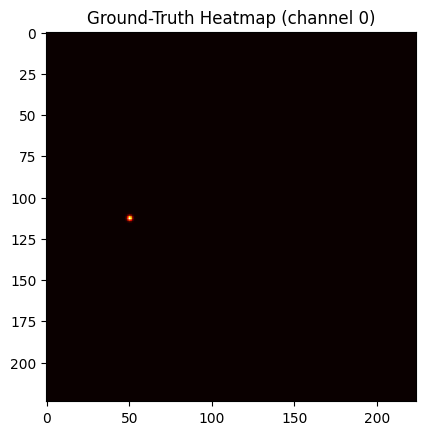

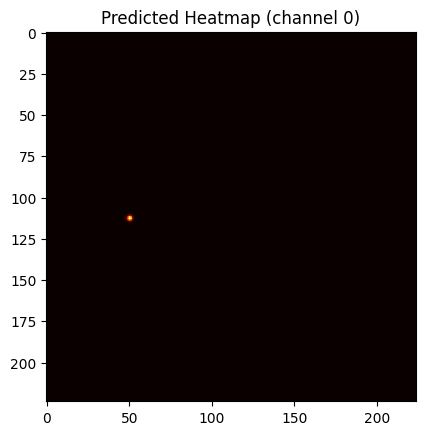

In [31]:
import matplotlib.pyplot as plt

gt_heatmap = hmaps[0, 0].detach().cpu().numpy()  # channel 0 of shape (224, 224)
plt.imshow(gt_heatmap, cmap='hot')
plt.title("Ground-Truth Heatmap (channel 0)")
plt.show()

model.eval()
with torch.no_grad():
    pred = model(imgs)  # (1, 68, 224, 224)
pred_heatmap = pred[0, 0].cpu().numpy()
plt.imshow(pred_heatmap, cmap='hot')
plt.title("Predicted Heatmap (channel 0)")
plt.show()


### Scale to entire dataet

In [32]:
# TODO: training code for UNet with heatmaps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from models import UnconditionalUNet
from tqdm import tqdm

# Training loop for U-Net
def train_unet(model, train_loader, val_loader, n_epochs=20, device="cuda", save_path="./models/unet_best.pth"):
    model.to(device)
    criterion = nn.MSELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []
    for epoch in tqdm(range(n_epochs), desc="training"):
        model.train()
        running_loss = 0.0

        for batch in tqdm(train_loader, desc=f"epoch {epoch}"):
        # for batch in train_loader:
            images = batch["image"].to(device)  # [B, 1, 224, 224]
            # heatmaps = generate_heatmaps_batch(batch["keypoints"].numpy())  # [B, 68, 64, 64]
            # heatmaps = torch.from_numpy(heatmaps).to(device).float()
            heatmaps = batch["heatmaps"].to(device)  # [B, 68, 224, 224]
            # print(heatmaps.shape)

            optimizer.zero_grad()
            outputs = model(images)
            # print(outputs.shape)
            loss = criterion(outputs, heatmaps)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # avg_train_loss = running_loss / len(train_loader)
        train_losses.append(running_loss)

        val_loss = validate_unet(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f}")
        if epoch in [0, 3, 15]:
            torch.save(model.state_dict(), f'./models/unet_epoch_{epoch}.pth')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'./models/unet_best.pth')
            print("Best model saved.")
    return train_losses, val_losses

# Validation loop
def validate_unet(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            heatmaps = batch["heatmaps"].to(device)
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            val_loss += loss.item()
    model.train()
    return val_loss

model = UnconditionalUNet(
    in_channels=1,
    num_hiddens=128
)
train_losses, val_losses = train_unet(model, train_loader, test_loader, n_epochs=5)

epoch 0: 100%|██████████| 109/109 [02:16<00:00,  1.25s/it]


Epoch 1/5 | Train Loss: 18249.2693 | Val Loss: 3991.3223


training:  20%|██        | 1/5 [02:51<11:26, 171.71s/it]

Best model saved.



epoch 1: 100%|██████████| 109/109 [02:16<00:00,  1.25s/it]


Epoch 2/5 | Train Loss: 16847.5698 | Val Loss: 3859.2149


training:  40%|████      | 2/5 [05:41<08:32, 170.67s/it]

Best model saved.



epoch 2: 100%|██████████| 109/109 [02:15<00:00,  1.24s/it]


Epoch 3/5 | Train Loss: 16211.1944 | Val Loss: 3657.2102


training:  60%|██████    | 3/5 [08:30<05:39, 169.79s/it]

Best model saved.



epoch 3: 100%|██████████| 109/109 [02:13<00:00,  1.23s/it]


Epoch 4/5 | Train Loss: 15822.6466 | Val Loss: 3627.0457


training:  80%|████████  | 4/5 [11:19<02:49, 169.40s/it]

Best model saved.



epoch 4: 100%|██████████| 109/109 [02:15<00:00,  1.24s/it]


Epoch 5/5 | Train Loss: 15545.9482 | Val Loss: 3597.0361


training: 100%|██████████| 5/5 [14:07<00:00, 169.55s/it]

Best model saved.


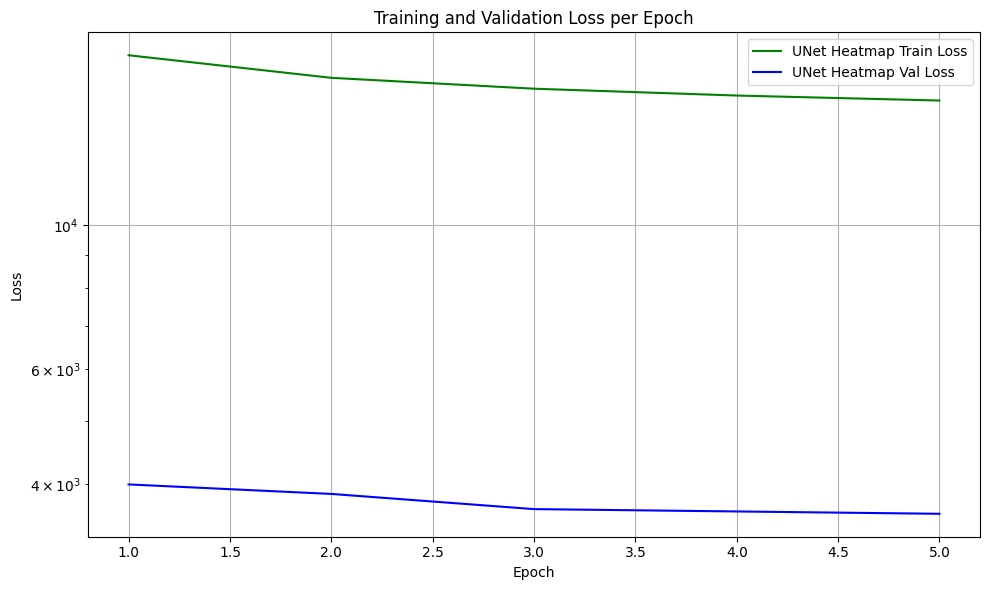

Final training loss: 15545.948204040527
Final val loss: 3597.036141395569
Best val loss: 3597.036141395569, epoch#: 4


In [33]:
# loss viz
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))


plt.plot(epochs, train_losses, label='UNet Heatmap Train Loss', color='green', linestyle='-')
plt.plot(epochs, val_losses, label='UNet Heatmap Val Loss', color='blue', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_losses[-1]}')
print(f'Final val loss: {val_losses[-1]}')

best_val_loss = min(val_losses)
best_epoch = val_losses.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

max index: (117, 66)
max index: (89, 55)
max index: (99, 62)
max index: (110, 102)
max index: (155, 81)
max index: (159, 83)
max index: (162, 84)
max index: (165, 94)
max index: (166, 107)
max index: (164, 120)
max index: (159, 128)
max index: (159, 130)
max index: (125, 172)
max index: (117, 172)
max index: (90, 153)
max index: (87, 151)
max index: (70, 127)
max index: (146, 10)
max index: (52, 63)
max index: (89, 94)
max index: (90, 98)
max index: (60, 67)
max index: (56, 94)
max index: (55, 98)
max index: (53, 119)
max index: (54, 121)
max index: (60, 131)
max index: (73, 82)
max index: (82, 78)
max index: (88, 78)
max index: (101, 74)
max index: (112, 85)
max index: (113, 85)
max index: (113, 90)
max index: (112, 95)
max index: (112, 99)
max index: (74, 63)
max index: (72, 66)
max index: (72, 71)
max index: (74, 114)
max index: (76, 72)
max index: (77, 67)
max index: (72, 98)
max index: (69, 103)
max index: (68, 109)
max index: (69, 122)
max index: (71, 109)
max index: (72, 103)
ma

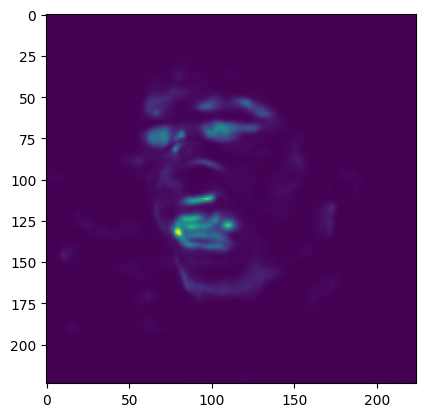

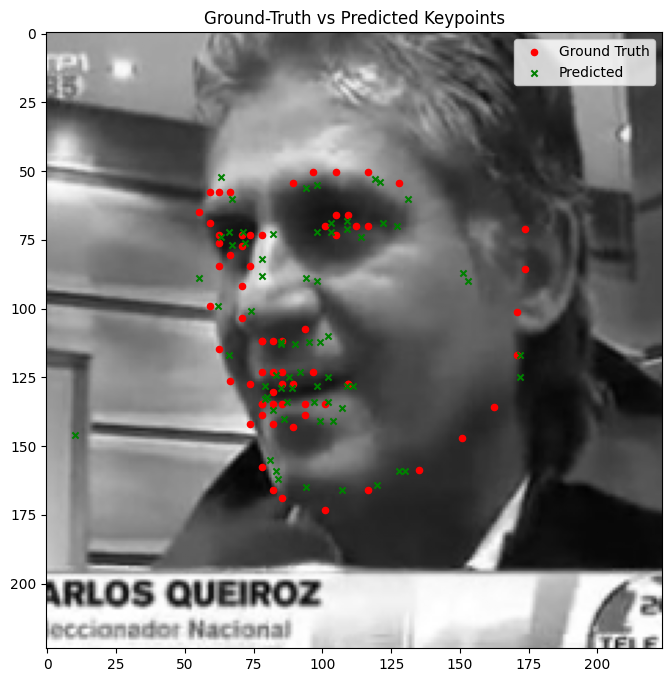

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnconditionalUNet(
    in_channels=1,
    num_hiddens=128
)
model.load_state_dict(torch.load("./models/unet_epoch_3.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    for i, sample in enumerate(test_loader):
        # 2) Move input images to GPU (if available)
        images_gpu = sample['image'].to(device)      # Shape [B, 1, 224, 224]

        # 3) Run inference -> predicted heatmaps
        pred_heatmaps = model(images_gpu)            # Shape [B, K, 224, 224]
        # print(pred_heatmaps[0][0].sum())
        heatmaps = pred_heatmaps[0].sum(dim=0, keepdim=True)
        plt.imshow(heatmaps.cpu().numpy().transpose(1, 2, 0))

        # Ground-truth keypoints (still on CPU)
        # Shape [B, K, 2], might be normalized or partially scaled
        gt_keypoints = sample['keypoints']

        # We'll visualize the first image in this batch
        b = 0

        # -- Prepare the raw image for plotting --
        image_np = sample['image'][b].numpy().transpose(1, 2, 0)  # shape (224, 224, 1)
        image_np = image_np.squeeze()  # -> shape (224, 224)

        # -- Ground-Truth Keypoints --
        # If your dataset keypoints are in some normalized form, apply the same
        # scaling/shift you used in your original snippet (*50 + 100).
        gt_kps = gt_keypoints[b].numpy()  # shape [K, 2]
        gt_x = gt_kps[:, 0] * 50 + 100
        gt_y = gt_kps[:, 1] * 50 + 100

        # -- Predicted Keypoints (Argmax in each heatmap) --
        pred_kps = []
        heatmaps_b = pred_heatmaps[b]  # shape [K, 224, 224]
        K = heatmaps_b.shape[0]

        for k in range(K):

            max_val = heatmaps_b[k].max()
            flat_idx = torch.argmax(heatmaps_b[k])
            row = flat_idx // 224
            col = flat_idx % 224
            print("max index:", (row.item(), col.item()))
            pred_kps.append([col.item(), row.item()])

        pred_kps = np.array(pred_kps)  # shape [K, 2]
        print((pred_kps[2]))

        # -- Visualization --
        plt.figure(figsize=(8, 8))
        plt.imshow(image_np, cmap="gray")

        # Plot ground-truth keypoints (red)
        plt.scatter(gt_x, gt_y, c='r', s=20, label='Ground Truth')
        # Plot predicted keypoints (green 'x')
        plt.scatter(pred_kps[:, 0], pred_kps[:, 1], c='g', marker='x', s=20, label='Predicted')

        plt.title("Ground-Truth vs Predicted Keypoints")
        plt.legend()
        plt.show()

        # Stop after visualizing the first batch
        break
